In [1]:
import sys
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from tqdm import tqdm
import random
import time
import itertools
import warnings

In [2]:
# provide the path to your local installation of the CROPseq-multi package
# set path to top level of git directory
gitdir = os.popen('git rev-parse --show-toplevel').read().strip('\n')
sys.path.append(gitdir+'/csm')
os.chdir(gitdir)

import guide_selection, barcode_selection, oligo_design

# overview

1) **design guide pairs for singles, combos, and controls** 

2) **select iBAR pairs** 

3) **randomly assign any unassigned tRNAs**

4) **generate oligos**

# 1. design guide pairs for singles, combos, and controls


## In this scheme, we will design an all-by-all combinatorial library.

Starting from a list of genes and specified N = number of constructs per target, the library will consist of:
1) N constructs that target each genes individually, each pairing a unique gene-targeting guide with a control guide
2) N constructs targeting all pairs of genes, each construct pairing a unique guide for each gene
3) control constructs composed of only control guides***

#### Starting with a list of genes, use CRISPick to design at least N guides per gene for the appropriate modality (i.e. KO, CRISPRi, CRISPRa, etc.)
- Proceed to CRISPick with a list of genes to design guides: https://portals.broadinstitute.org/gppx/crispick/public

#### Guide pairing criteria
- We will prioritize using the best a priori ranking ("Pick Order") guides, in descending order, and uniform guide positioning (position and adjacent tRAN) in single and combination constructs.
    -   When possible, the spacer assigned to position 2 will be paired to the same middle tRNA to which it is immediately adjacent. Thus, a spacer assigned to postiion 1 can be paired with any middle tRNA.
    - Consistent sgRNA position will be prioritized over the exact pairing of sgRNA Pick Orders.

For even numbers of constructs per gene, we will prioritize keeping the position of each guide constant, allowing different combinations of pick orders. For example, a library of three genes (A, B, and C) and two constructs per gene:

|target | construct_1 | construct_2 |
|---|---|---|
|A_B|gA1-tRNA_A-gB1 | gB2-tRNA_Q-gA2 |
|A_C| gA1-tRNA_P-gC1 | gC2-tRNA_Q-gA2 |
|B_C| gB2-tRNA_P-gC1 | gC2-tRNA_A-gB1 |
|A| gA1-tRNA_A-gCTRL | gNT-tRNA_Q-gA2 |
|B| gNT-tRNA_A-gB1 | gB2-tRNA_P-gCTRL |
|C| gNT-tRNA_P-gC1 | gC2-tRNA_Q-gCTRL |
* *consitent guide positioning: Note that gB1, for example, is always in position 2 and adjacent to tRNA_A.*
* *varied pick order combinations: The pairing of pick orders is allowed to vary in order to hold guide position constant. For example, gA1 is paired with gB1 (both pick order 1) but gC1 is paired with gB2 (pick orders 1 and 2, respectively).*


For odd numbers of constructs per gene, we will prioritize keeping the position of each guide constant allowing different combinations of pick orders, however the lowest pick order guide will be allowed to change position when unavoidable. For example, a library of three genes (A, B, and C) and three constructs per gene:

|target | construct_1  | construct_2  | construct_3 |
|---|---|---|---|
|A_B|  gA1-tRNA_A-gB1  | gB2-tRNA_P-gA2 | gA3-tRNA_Q-gB3 | 
|A_C|  gA1-tRNA_Q-gC1 | gC2-tRNA_P-gA2 | gA3-tRNA_A-**gC3** | 
|B_C|  gB2-tRNA_Q-gC1 | gC2-tRNA_A-gB1 | **gC3**-tRNA_Q-gB3 | 
|A|  gA1-tRNA_P-gCTRL | gCTRL-tRNA_P-gA2  | gA3-tRNA_Q-CTRL | 
|B|  gCTRL-tRNA_A-gB1 | gB2-tRNA_Q-gCTRL | gCTRL-tRNA_Q-gB3 | 
|C|  gCTRL-tRNA_Q-gC1 | gC2-tRNA_P-gCTRL | gCTR-tRNA_A-**gC3** | 
* *consitent guide positioning: Note that gB1, for example, is always in position 2 and adjacent to tRNA_A.*
* *varied pick order combinations: The pairing of pick orders is allowed to vary in order to hold guide position constant. For example, gA1 is paired with gB1 (both pick order 1) but gC1 is paired with gB2 (pick orders 1 and 2, respectively)*
* *unavoidable inconsitent guide positioning: note that gC3 (pick order 3, the lowest rank for N=3), for example, is required to have inconsistent positioning to accomodate the position requirements of other guides.*


In [3]:
# load gene-targeting guides designed with CRISPick
df_guides = pd.read_table('input_files/cc392949-c8eb-455d-8bd3-b33990900874-sgrna-designs.txt')

# load a set of control guides designed with CRISPick
df_controls = pd.read_table('input_files/CRISPick_Jacquere_top_intergenic_guides.txt')

# select the number of targets per gene
n_constructs_per_target = 3

df_guide_pairs = guide_selection.design_all_by_all(df_guides, df_controls, n_constructs_per_target)
df_guide_pairs

,target,target_symbol,targeting_spacer_pos,targeting_spacer_pick_order,control_spacer_pos,target_ID_pos_1,target_symbol_pos_1,spacer_1,pick_order_pos_1,target_ID_pos_2,target_symbol_pos_2,spacer_2,pick_order_pos_2,tRNA,target_version,category,pick_sum
0,ENSG00000039068,CDH1,2.0,1.0,1.0,INTERGENIC_CONTROL_chr8,INTERGENIC_CONTROL_chr8,TGGGGCTAGATGTTATATCC,1,ENSG00000039068,CDH1,GCTGAGGATGGTGTAAGCGA,1,tRNA_A,1,SINGLE_GENE_TARGETING,NaN
1,ENSG00000039068,CDH1,1.0,2.0,2.0,ENSG00000039068,CDH1,GCGCGCCCTCACCTCTGCCC,2,INTERGENIC_CONTROL_chr4,INTERGENIC_CONTROL_chr4,TTAATCATAACAGTCTACCC,1,tRNA_Q,2,SINGLE_GENE_TARGETING,NaN
2,ENSG00000039068,CDH1,2.0,3.0,1.0,INTERGENIC_CONTROL_chr3,INTERGENIC_CONTROL_chr3,ACCCAGCCAGCTGGCAGCAC,1,ENSG00000039068,CDH1,GCAATGCGTTCTCTATCCAG,3,tRNA_P,3,SINGLE_GENE_TARGETING,NaN
3,ENSG00000170558,CDH2,2.0,1.0,1.0,INTERGENIC_CONTROL_chr14,INTERGENIC_CONTROL_chr14,GGTGTGTGCAAGGGTTACAC,1,ENSG00000170558,CDH2,GTGGCGGAGATCCTACTGGA,1,tRNA_A,1,SINGLE_GENE_TARGETING,NaN
4,ENSG00000170558,CDH2,1.0,2.0,2.0,ENSG00000170558,CDH2,ACCGTCATGGCAGTAAACTC,2,INTERGENIC_CONTROL_chr16,INTERGENIC_CONTROL_chr16,TGTATATTAGTCCACTACCA,1,tRNA_A,2,SINGLE_GENE_TARGETING,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3973,ENSG00000102349_ENSG00000076706,KLF8_MCAM,NaN,NaN,NaN,ENSG00000076706,MCAM,AGTGGGCGCTATGAATGTCA,2,ENSG00000102349,KLF8,TGTTGACGTGGACACCACAA,2,tRNA_P,2,COMBO_GENE_TARGETING,4.0
3974,ENSG00000102349_ENSG00000076706,KLF8_MCAM,NaN,NaN,NaN,ENSG00000102349,KLF8,GCTACCAGTGCTCTGAGAGG,3,ENSG00000076706,MCAM,GGAGAGGCCGCACTTCAGAA,3,tRNA_P,3,COMBO_GENE_TARGETING,6.0
3975,ENSG00000135862_ENSG00000076706,LAMC1_MCAM,NaN,NaN,NaN,ENSG00000135862,LAMC1,TCAGTGAGAGAATGGAATCC,2,ENSG00000076706,MCAM,GTTGAGCTCACAGTAAAACT,1,tRNA_A,1,COMBO_GENE_TARGETING,3.0
3976,ENSG00000135862_ENSG00000076706,LAMC1_MCAM,NaN,NaN,NaN,ENSG00000076706,MCAM,AGTGGGCGCTATGAATGTCA,2,ENSG00000135862,LAMC1,AAATGGCAAAGCTCTCCGGG,1,tRNA_Q,2,COMBO_GENE_TARGETING,3.0


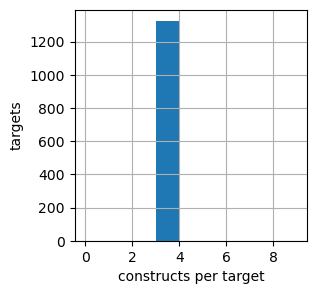

In [4]:
plt.figure(figsize=(3,3))
df_guide_pairs.value_counts('target').hist(bins=range(0,10))
plt.xlabel('constructs per target')
plt.ylabel('targets')
plt.show()

### now let's add some controls

Here, we'll add 100 constructs pairing nontargeting guides and 100 constructs pairing intergenic targeting guides.

In [5]:
control_pairs_df = guide_selection.pair_guides_single_target_controls(
    n_intergenic_constructs = 100, # number of intergenic control constructs
    n_nontargeting_constructs = 100, # number of nontargeting control constructs
)

### combine gene-targeting and control pairs

In [6]:
guide_pairs_df = pd.concat([df_guide_pairs, control_pairs_df],
                           ignore_index=True).reset_index(drop=True)
    
guide_pairs_df

,target,target_symbol,targeting_spacer_pos,targeting_spacer_pick_order,control_spacer_pos,target_ID_pos_1,target_symbol_pos_1,spacer_1,pick_order_pos_1,target_ID_pos_2,target_symbol_pos_2,spacer_2,pick_order_pos_2,tRNA,target_version,category,pick_sum,spacer_1_pick_order,spacer_2_pick_order
0,ENSG00000039068,CDH1,2.0,1.0,1.0,INTERGENIC_CONTROL_chr8,INTERGENIC_CONTROL_chr8,TGGGGCTAGATGTTATATCC,1.0,ENSG00000039068,CDH1,GCTGAGGATGGTGTAAGCGA,1.0,tRNA_A,1,SINGLE_GENE_TARGETING,NaN,NaN,NaN
1,ENSG00000039068,CDH1,1.0,2.0,2.0,ENSG00000039068,CDH1,GCGCGCCCTCACCTCTGCCC,2.0,INTERGENIC_CONTROL_chr4,INTERGENIC_CONTROL_chr4,TTAATCATAACAGTCTACCC,1.0,tRNA_Q,2,SINGLE_GENE_TARGETING,NaN,NaN,NaN
2,ENSG00000039068,CDH1,2.0,3.0,1.0,INTERGENIC_CONTROL_chr3,INTERGENIC_CONTROL_chr3,ACCCAGCCAGCTGGCAGCAC,1.0,ENSG00000039068,CDH1,GCAATGCGTTCTCTATCCAG,3.0,tRNA_P,3,SINGLE_GENE_TARGETING,NaN,NaN,NaN
3,ENSG00000170558,CDH2,2.0,1.0,1.0,INTERGENIC_CONTROL_chr14,INTERGENIC_CONTROL_chr14,GGTGTGTGCAAGGGTTACAC,1.0,ENSG00000170558,CDH2,GTGGCGGAGATCCTACTGGA,1.0,tRNA_A,1,SINGLE_GENE_TARGETING,NaN,NaN,NaN
4,ENSG00000170558,CDH2,1.0,2.0,2.0,ENSG00000170558,CDH2,ACCGTCATGGCAGTAAACTC,2.0,INTERGENIC_CONTROL_chr16,INTERGENIC_CONTROL_chr16,TGTATATTAGTCCACTACCA,1.0,tRNA_A,2,SINGLE_GENE_TARGETING,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4173,INTERGENIC_CONTROL_chrX_69159223-69159811,INTERGENIC_CONTROL_chrX,NaN,NaN,NaN,NaN,NaN,ACATGTGTGAAGTTCTCTAG,NaN,NaN,NaN,AATGCTTAAGAATGTCTGGA,NaN,NaN,4,INTERGENIC_CONTROL,NaN,1,1
4174,INTERGENIC_CONTROL_chrX_94426300-94431526,INTERGENIC_CONTROL_chrX,NaN,NaN,NaN,NaN,NaN,TAAGGTAGAGAGTTACTATG,NaN,NaN,NaN,GTAGCTGTACAATTAACGCT,NaN,NaN,5,INTERGENIC_CONTROL,NaN,1,1
4175,INTERGENIC_CONTROL_chrX_106225574-106227587,INTERGENIC_CONTROL_chrX,NaN,NaN,NaN,NaN,NaN,TGTAAGGTATGTATAGGTCA,NaN,NaN,NaN,CAAGATAGGTACATCCTGTT,NaN,NaN,6,INTERGENIC_CONTROL,NaN,1,1
4176,INTERGENIC_CONTROL_chrX_142843316-142847680,INTERGENIC_CONTROL_chrX,NaN,NaN,NaN,NaN,NaN,GTGTTGCTGACCTAGCAATA,NaN,NaN,NaN,TATCCAGGTAGTATGCTACG,NaN,NaN,7,INTERGENIC_CONTROL,NaN,1,1


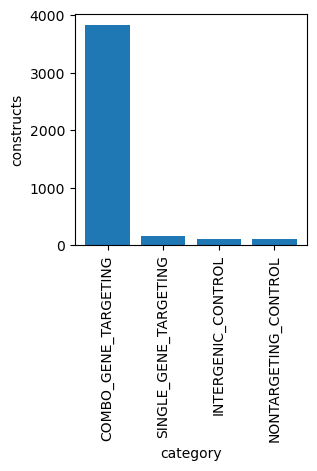

In [7]:
plt.figure(figsize=(3,3))
plt.bar(guide_pairs_df.value_counts('category').index,
        guide_pairs_df.value_counts('category').values)
plt.xlabel('category')
plt.xticks(rotation=90)
plt.ylabel('constructs')
plt.show()

# 2. iBAR selection

### For this combinatorial library, we have opted to assign unique iBARs to all sgRNAs. Though individual spacers are used in multiple constructs, each individual sgRNA is addressed to a specific combinatorial target via the iBAR.

## A brief overview of methods for iBAR pairing

There are diverse ways to encode information in iBARs, with some methods offering distinct advantages. We have implemented a few methods, described below.

For optical pooled screening applications, consider if you will employ multiplexed decoding (mRNA detection) or serial decoding (T7 IVT detection).

### 1) 'positional'
- all iBARs are unique (iBARs are *not* repeated in either position) and iBAR position is encoded in the first base identity
    - iBAR1 starts with 'A' or 'G' (5'-3' mRNA orientation)
    - iBAR2 starts with 'C' or 'T' (5'-3' mRNA orientation)
- there is a guaranteed edit distance between all iBARs in a library
- compatible with repurposing iBAR2 as a unique molecular identifier
- for optical pooled screens:
    - multiplexed decoding (mRNA) enables recombination detection and more efficient decoding
        - observation of either barcode alone is sufficient to identify a construct
    - for serial decoding (T7 IVT), modestly less efficient decoding vs 'random_shared', 'random_unique', or 'matched'

### 2) 'random_unique'
- all iBARs are unique (iBARs are *not* repeated in either position) 
- there is a guaranteed edit distance between all iBARs in the library
- compatible with repurposing iBAR2 as a unique molecular identifier
- for optical pooled screens:
    - multiplexed decoding (mRNA) enables recombination detection and more efficient decoding
        - observation of either barcode alone is sufficient to identify a construct, even if the position (iBAR1 or iBAR2) is unknown

### 3) 'random_shared'
- iBARs are unique to a position (i.e. iBAR1 or iBAR2) but shared between positions (iBARs *may be* repeated between positions 1 and 2)
    - iBAR pairs are unique, independent of position (we do not allow BC1-BC2 and BC2-BC1 to co-occur)
- there is a guaranteed edit distance between all iBARs in a position (iBAR1 or iBAR2)
- yield approximately twice as many barcode pairs as 'random_unique' for a given barcode length and edit distance
- compatible with repurposing iBAR2 as a unique molecular identifier
- for optical pooled screens:
    - multiplexed decoding (mRNA) enables recombination detection and more efficient decoding
        - observation of either barcode alone is sufficient to identify a construct, *only if* the position (iBAR1 or iBAR2) is known

### 4) 'matched'
- both iBARs of a construct are the same barcode (i.e. iBAR1 = iBAR2)
- across constructs, there is a guaranteed edit distance between iBARs
- yield approximately twice as many barcode pairs as 'random_unique' for a given barcode length and edit distance
- compatible with repurposing iBAR2 as a unique molecular identifier
- for optical pooled screens:
    - no advantage in decoding efficiency for multiplexed decoding (mRNA) compared to serial decoding (T7 IVT)

### pre-computed barcode sets

- barcodes within a set have a guaranteed edit distance of 2 (error detection) or 3 (error correction)
- barcodes are not necessarily compatible across these sets
- these sets were designed with the dna-barcodes repository (https://github.com/feldman4/dna-barcodes) and we recommend this tool for the generation of additional barcode sets

In [8]:
# import all the barcode sets
df_bc_sets = pd.DataFrame()
search = 'designed_barcode_sets/barcodes_n*_k*_*.noBsmBI.csv'
for file in glob(search):
    df_barcodes = pd.read_csv(file)
    df_bc_sets.loc[file, 'length'] = df_barcodes['n'][0]
    df_bc_sets.loc[file, 'distance'] = df_barcodes['k'][0]
    df_bc_sets.loc[file, 'metric'] = file.split('_')[-1].split('.')[0]
    df_bc_sets.loc[file, 'n_barcodes'] = len(df_barcodes)

df_bc_sets.sort_values('n_barcodes')

,length,distance,metric,n_barcodes
designed_barcode_sets/barcodes_n6_k3_Levenshtein.noBsmBI.csv,6.0,3.0,Levenshtein,87.0
designed_barcode_sets/barcodes_n7_k3_Levenshtein.noBsmBI.csv,7.0,3.0,Levenshtein,230.0
designed_barcode_sets/barcodes_n8_k3_Levenshtein.noBsmBI.csv,8.0,3.0,Levenshtein,835.0
designed_barcode_sets/barcodes_n6_k2_Levenshtein.noBsmBI.csv,6.0,2.0,Levenshtein,883.0
designed_barcode_sets/barcodes_n7_k2_Levenshtein.noBsmBI.csv,7.0,2.0,Levenshtein,1991.0
designed_barcode_sets/barcodes_n9_k3_Levenshtein.noBsmBI.csv,9.0,3.0,Levenshtein,3054.0
designed_barcode_sets/barcodes_n10_k3_Levenshtein.noBsmBI.csv,10.0,3.0,Levenshtein,10644.0
designed_barcode_sets/barcodes_n8_k2_Levenshtein.noBsmBI.csv,8.0,2.0,Levenshtein,12606.0
designed_barcode_sets/barcodes_n9_k2_Levenshtein.noBsmBI.csv,9.0,2.0,Levenshtein,42534.0
designed_barcode_sets/barcodes_n12_k3_Levenshtein.noBsmBI.csv,12.0,3.0,Levenshtein,62679.0


In [9]:
library_design_df = barcode_selection.automated_iBAR_assignment(guide_pairs_df, distance=3, method='random_unique')


Edit distance 3 in 10 cycles

generating and filtering complete iBARs...


100%|██████████| 10644/10644 [00:00<00:00, 48250.51it/s]



optimizing barcode pairing...
attempt 1/3


100%|██████████| 31518/31518 [00:00<00:00, 1092105.33it/s]


attempt 2/3


100%|██████████| 493194/493194 [00:00<00:00, 1037431.68it/s]


attempt 3/3


100%|██████████| 6671852/6671852 [00:08<00:00, 747503.47it/s]



designed 4852 barcode pairs

determining cycling requirements for decoding...

barcode 1 is unique in set(barcode 1) in:
 8 cycles

barcode 2 is unique in set(barcode 2) in:
 8 cycles

barcodes in set(barcode 1, barcode 2) are unique in:
 8 cycles

simulating recombination detection...



barcode pair is unique in set(1-2, 2-1) in :
 6 cycles with 100% recombination detection

simulating recombination detection...



barcode pair is unique in set(1-2) in:
 6 cycles with 100% recombination detection


# 3. randomly assign any unassigned tRNAs

in this case, only negative controls have not been assigned tRNAs

In [10]:
library_design_df = oligo_design.assign_tRNAs(library_design_df)
library_design_df

,target,target_symbol,targeting_spacer_pos,targeting_spacer_pick_order,control_spacer_pos,target_ID_pos_1,target_symbol_pos_1,spacer_1,pick_order_pos_1,target_ID_pos_2,target_symbol_pos_2,spacer_2,pick_order_pos_2,tRNA,target_version,category,pick_sum,spacer_1_pick_order,spacer_2_pick_order,iBAR_1,iBAR_2
0,ENSG00000039068,CDH1,2.0,1.0,1.0,INTERGENIC_CONTROL_chr8,INTERGENIC_CONTROL_chr8,TGGGGCTAGATGTTATATCC,1.0,ENSG00000039068,CDH1,GCTGAGGATGGTGTAAGCGA,1.0,tRNA_A,1,SINGLE_GENE_TARGETING,NaN,NaN,NaN,CATGATTACTAC,ACGACCCGAAAC
1,ENSG00000039068,CDH1,1.0,2.0,2.0,ENSG00000039068,CDH1,GCGCGCCCTCACCTCTGCCC,2.0,INTERGENIC_CONTROL_chr4,INTERGENIC_CONTROL_chr4,TTAATCATAACAGTCTACCC,1.0,tRNA_Q,2,SINGLE_GENE_TARGETING,NaN,NaN,NaN,ATCGGAGTGGCT,TAACTCTCCCAT
2,ENSG00000039068,CDH1,2.0,3.0,1.0,INTERGENIC_CONTROL_chr3,INTERGENIC_CONTROL_chr3,ACCCAGCCAGCTGGCAGCAC,1.0,ENSG00000039068,CDH1,GCAATGCGTTCTCTATCCAG,3.0,tRNA_P,3,SINGLE_GENE_TARGETING,NaN,NaN,NaN,AATAGCTTTGCT,TAATGAGACAAG
3,ENSG00000170558,CDH2,2.0,1.0,1.0,INTERGENIC_CONTROL_chr14,INTERGENIC_CONTROL_chr14,GGTGTGTGCAAGGGTTACAC,1.0,ENSG00000170558,CDH2,GTGGCGGAGATCCTACTGGA,1.0,tRNA_A,1,SINGLE_GENE_TARGETING,NaN,NaN,NaN,GCGTTGTCTAAA,TGCCCGAACGAA
4,ENSG00000170558,CDH2,1.0,2.0,2.0,ENSG00000170558,CDH2,ACCGTCATGGCAGTAAACTC,2.0,INTERGENIC_CONTROL_chr16,INTERGENIC_CONTROL_chr16,TGTATATTAGTCCACTACCA,1.0,tRNA_A,2,SINGLE_GENE_TARGETING,NaN,NaN,NaN,CTGAATAAACGT,GGTGTCGCAATA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4173,INTERGENIC_CONTROL_chrX_69159223-69159811,INTERGENIC_CONTROL_chrX,NaN,NaN,NaN,NaN,NaN,ACATGTGTGAAGTTCTCTAG,NaN,NaN,NaN,AATGCTTAAGAATGTCTGGA,NaN,tRNA_A,4,INTERGENIC_CONTROL,NaN,1,1,GAATAGTTGTGA,CCCGACAACTGG
4174,INTERGENIC_CONTROL_chrX_94426300-94431526,INTERGENIC_CONTROL_chrX,NaN,NaN,NaN,NaN,NaN,TAAGGTAGAGAGTTACTATG,NaN,NaN,NaN,GTAGCTGTACAATTAACGCT,NaN,tRNA_Q,5,INTERGENIC_CONTROL,NaN,1,1,CAGTTTGCTTAA,CGTATCGCGAAA
4175,INTERGENIC_CONTROL_chrX_106225574-106227587,INTERGENIC_CONTROL_chrX,NaN,NaN,NaN,NaN,NaN,TGTAAGGTATGTATAGGTCA,NaN,NaN,NaN,CAAGATAGGTACATCCTGTT,NaN,tRNA_Q,6,INTERGENIC_CONTROL,NaN,1,1,AAATTTCACCCG,TCAGTTTGCAAA
4176,INTERGENIC_CONTROL_chrX_142843316-142847680,INTERGENIC_CONTROL_chrX,NaN,NaN,NaN,NaN,NaN,GTGTTGCTGACCTAGCAATA,NaN,NaN,NaN,TATCCAGGTAGTATGCTACG,NaN,tRNA_A,7,INTERGENIC_CONTROL,NaN,1,1,CTTATCGACAAT,CGCTTGGGACTC


# 4. generate oligos

- successful oligo designs will populate the 'oligo' column in oligo_design_df
- if any oligos were not successfully built, those rows will be returned in 'df_failed' for inspesction
  - if all oligos were successfully built, 'df_failed' will be an empty dataframe
- tRNAs may be substituted at this step to remove incompatible sequences.

In [11]:
# inspect any designs for which oligos could not be built
# (empty dataframe if there were no failures)
oligo_design_df, df_failed = oligo_design.generate_oligos(library_design_df)

changed a tRNA from tRNA_Q to tRNA_A
changed a tRNA from tRNA_Q to tRNA_A
changed a tRNA from tRNA_P to tRNA_A
changed a tRNA from tRNA_Q to tRNA_A


In [12]:
df_failed

""


In [13]:
# successful designs
oligo_design_df

,target,target_symbol,targeting_spacer_pos,targeting_spacer_pick_order,control_spacer_pos,target_ID_pos_1,target_symbol_pos_1,spacer_1,pick_order_pos_1,target_ID_pos_2,target_symbol_pos_2,spacer_2,pick_order_pos_2,tRNA,target_version,category,pick_sum,spacer_1_pick_order,spacer_2_pick_order,iBAR_1,iBAR_2,dialout,dialout_fwd,dialout_rev,tRNA_leader,oligo,oligo_len
0,ENSG00000039068,CDH1,2.0,1.0,1.0,INTERGENIC_CONTROL_chr8,INTERGENIC_CONTROL_chr8,TGGGGCTAGATGTTATATCC,1.0,ENSG00000039068,CDH1,GCTGAGGATGGTGTAAGCGA,1.0,tRNA_A,1,SINGLE_GENE_TARGETING,NaN,NaN,NaN,CATGATTACTAC,ACGACCCGAAAC,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCATGGGGCTAGATGTTATATCC...,300
1,ENSG00000039068,CDH1,1.0,2.0,2.0,ENSG00000039068,CDH1,GCGCGCCCTCACCTCTGCCC,2.0,INTERGENIC_CONTROL_chr4,INTERGENIC_CONTROL_chr4,TTAATCATAACAGTCTACCC,1.0,tRNA_Q,2,SINGLE_GENE_TARGETING,NaN,NaN,NaN,ATCGGAGTGGCT,TAACTCTCCCAT,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCAGCGCGCCCTCACCTCTGCCC...,300
2,ENSG00000039068,CDH1,2.0,3.0,1.0,INTERGENIC_CONTROL_chr3,INTERGENIC_CONTROL_chr3,ACCCAGCCAGCTGGCAGCAC,1.0,ENSG00000039068,CDH1,GCAATGCGTTCTCTATCCAG,3.0,tRNA_P,3,SINGLE_GENE_TARGETING,NaN,NaN,NaN,AATAGCTTTGCT,TAATGAGACAAG,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCAACCCAGCCAGCTGGCAGCAC...,300
3,ENSG00000170558,CDH2,2.0,1.0,1.0,INTERGENIC_CONTROL_chr14,INTERGENIC_CONTROL_chr14,GGTGTGTGCAAGGGTTACAC,1.0,ENSG00000170558,CDH2,GTGGCGGAGATCCTACTGGA,1.0,tRNA_A,1,SINGLE_GENE_TARGETING,NaN,NaN,NaN,GCGTTGTCTAAA,TGCCCGAACGAA,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCAGGTGTGTGCAAGGGTTACAC...,300
4,ENSG00000170558,CDH2,1.0,2.0,2.0,ENSG00000170558,CDH2,ACCGTCATGGCAGTAAACTC,2.0,INTERGENIC_CONTROL_chr16,INTERGENIC_CONTROL_chr16,TGTATATTAGTCCACTACCA,1.0,tRNA_A,2,SINGLE_GENE_TARGETING,NaN,NaN,NaN,CTGAATAAACGT,GGTGTCGCAATA,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCAACCGTCATGGCAGTAAACTC...,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4173,INTERGENIC_CONTROL_chrX_69159223-69159811,INTERGENIC_CONTROL_chrX,NaN,NaN,NaN,NaN,NaN,ACATGTGTGAAGTTCTCTAG,NaN,NaN,NaN,AATGCTTAAGAATGTCTGGA,NaN,tRNA_A,4,INTERGENIC_CONTROL,NaN,1,1,GAATAGTTGTGA,CCCGACAACTGG,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCAACATGTGTGAAGTTCTCTAG...,300
4174,INTERGENIC_CONTROL_chrX_94426300-94431526,INTERGENIC_CONTROL_chrX,NaN,NaN,NaN,NaN,NaN,TAAGGTAGAGAGTTACTATG,NaN,NaN,NaN,GTAGCTGTACAATTAACGCT,NaN,tRNA_Q,5,INTERGENIC_CONTROL,NaN,1,1,CAGTTTGCTTAA,CGTATCGCGAAA,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCATAAGGTAGAGAGTTACTATG...,300
4175,INTERGENIC_CONTROL_chrX_106225574-106227587,INTERGENIC_CONTROL_chrX,NaN,NaN,NaN,NaN,NaN,TGTAAGGTATGTATAGGTCA,NaN,NaN,NaN,CAAGATAGGTACATCCTGTT,NaN,tRNA_Q,6,INTERGENIC_CONTROL,NaN,1,1,AAATTTCACCCG,TCAGTTTGCAAA,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCATGTAAGGTATGTATAGGTCA...,300
4176,INTERGENIC_CONTROL_chrX_142843316-142847680,INTERGENIC_CONTROL_chrX,NaN,NaN,NaN,NaN,NaN,GTGTTGCTGACCTAGCAATA,NaN,NaN,NaN,TATCCAGGTAGTATGCTACG,NaN,tRNA_A,7,INTERGENIC_CONTROL,NaN,1,1,CTTATCGACAAT,CGCTTGGGACTC,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCAGTGTTGCTGACCTAGCAATA...,300


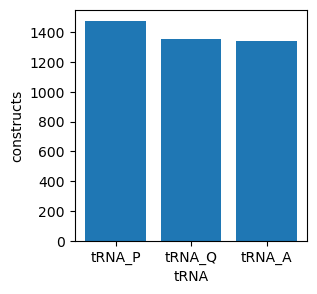

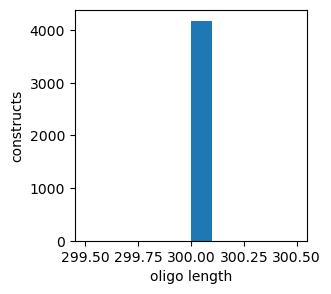

In [14]:
plt.figure(figsize=(3,3))
plt.bar(oligo_design_df.value_counts('tRNA').index, oligo_design_df.value_counts('tRNA').values)
plt.xlabel('tRNA')
plt.ylabel('constructs')
plt.show()

plt.figure(figsize=(3,3))
plt.hist(oligo_design_df.oligo_len)
plt.xlabel('oligo length')
plt.ylabel('constructs')
plt.show()

In [15]:
# oligo_design_df.to_csv('oligo_designs/CSM_library_design.%s.csv'%(time.strftime("%Y%m%d-%H%M%S")),index=False)
# oligo_design_df['oligo'].to_csv('oligo_designs/CSM_oligo_order.%s.csv'%(time.strftime("%Y%m%d-%H%M%S")))